In [1]:
import pandas as pd
import numpy as np
from cleantext import clean
import re
from transformers import (
    XLNetTokenizer,
    XLNetForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline,
)
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datasets
import evaluate
import random

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


### Preprocess our data


In [2]:
data_train = pd.read_csv("./EmotionData/emotion-labels-train.csv")
data_test = pd.read_csv("./EmotionData/emotion-labels-test.csv")
data_val = pd.read_csv("./EmotionData/emotion-labels-val.csv")

In [3]:
data_train.head()

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy


In [4]:
data = pd.concat([data_train, data_test, data_val], ignore_index=True)

In [9]:
data["text_clean"] = data["text"].apply(
    lambda x: clean(
        x,
        no_emoji=True,
        no_punct=True,
        lower=True,
    )
)

In [10]:
data.head(20)

,text,label,text_clean
0,Just got back from seeing @GaryDelaney in Burs...,joy,just got back from seeing garydelaney in bursl...
1,Oh dear an evening of absolute hilarity I don'...,joy,oh dear an evening of absolute hilarity i dont...
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,been waiting all week for this game cheer friday
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,gardinerlove thank you so much gloria youre so...
4,I feel so blessed to work with the family that...,joy,i feel so blessed to work with the family that...
5,"Today I reached 1000 subscribers on YT!! , #go...",joy,today i reached 1000 subscribers on yt goodday...
6,"@Singaholic121 Good morning, love! Happy first...",joy,singaholic121 good morning love happy first da...
7,#BridgetJonesBaby is the best thing I've seen ...,joy,bridgetjonesbaby is the best thing ive seen in...
8,Just got back from seeing @GaryDelaney in Burs...,joy,just got back from seeing garydelaney in bursl...
9,@IndyMN I thought the holidays could not get a...,joy,indymn i thought the holidays could not get an...


<Axes: xlabel='label'>

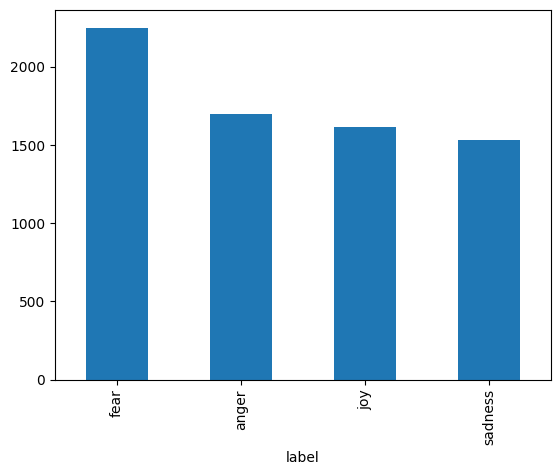

In [ ]:
data["label"].value_counts().plot(kind="bar")

In [ ]:
g = data.groupby("label")
data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))

<Axes: xlabel='label'>

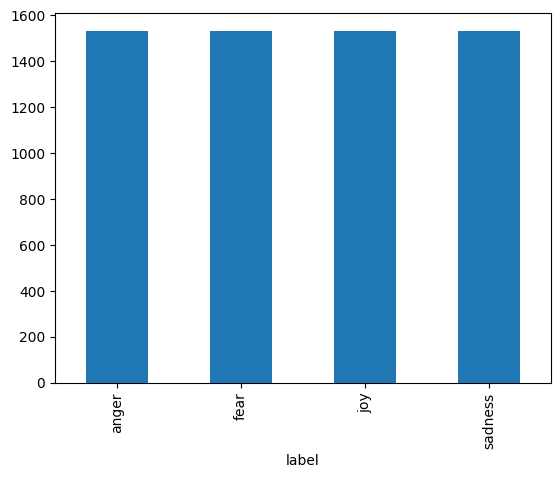

In [ ]:
data["label"].value_counts().plot(kind="bar")

In [ ]:
data["label_int"] = LabelEncoder().fit_transform(data["label"])
data.head()

text  ... label_int
label                                                       ...          
anger 0  @BigBrother__USA she is just jealous and a cry...  ...         0
      1  @Bell @Bell_Support Cancelling home Fibe, Inte...  ...         0
      2  when you find out the initiative isn't even a ...  ...         0
      3  @Bickley_Marotta yea because forcing 5 turnove...  ...         0
      4  @HannahFJames I'm distraught! 😭 Candice and he...  ...         0

[5 rows x 4 columns]

In [ ]:
NUM_LABELS = data["label_int"].nunique()
NUM_LABELS

4

In [16]:
train_split, test_split = train_test_split(data, train_size=0.8, random_state=42)
train_split, val_split = train_test_split(train_split, train_size=0.9, random_state=42)

In [18]:
print(len(train_split))
print(len(test_split))
print(len(val_split))

4414
1227
491


In [19]:
train_df = pd.DataFrame(
    {"label": train_split["label_int"].values, "text": train_split["text_clean"].values}
)

test_df = pd.DataFrame(
    {"label": test_split["label_int"].values, "text": test_split["text_clean"].values}
)

val_df = pd.DataFrame(
    {"label": val_split["label_int"].values, "text": val_split["text_clean"].values}
)

In [20]:
train_df = datasets.Dataset.from_dict(train_df)
test_df = datasets.Dataset.from_dict(test_df)
val_df = datasets.Dataset.from_dict(val_df)

In [21]:
dataset_dict = datasets.DatasetDict(
    {"train": train_df, "test": test_df, "validation": val_df}
)

In [22]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 4414
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1227
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 491
    })
})

### Create embeddings


In [23]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

In [24]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128,
    )

In [25]:
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/4414 [00:00<?, ? examples/s]

Map:   0%|          | 0/1227 [00:00<?, ? examples/s]

Map:   0%|          | 0/491 [00:00<?, ? examples/s]

In [27]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4414
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1227
    })
    validation: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 491
    })
})

In [ ]:
print(tokenized_datasets["train"]["text"][0])

antoboyle i so wish you could someday come to spain with the play i cant believe im not going to see it sad


In [ ]:
print(tokenized_datasets["train"]["input_ids"][0])

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 48, 261, 6549, 529, 17, 150, 102, 2022, 44, 121, 20078, 280, 22, 11951, 153, 33, 18, 354, 17, 150, 64, 46, 676, 7693, 50, 223, 22, 197, 36, 5694, 4, 3]


In [32]:
tokenizer.decode(5)

'<pad>'

In [ ]:
print(tokenized_datasets["train"]["token_type_ids"][0])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]


In [ ]:
print(tokenized_datasets["train"]["attention_mask"][0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [35]:
small_train_dataset = (
    tokenized_datasets["train"].shuffle(seed=42).select([i for i in list(range(100))])
)
small_eval_dataset = (
    tokenized_datasets["test"].shuffle(seed=42).select([i for i in list(range(100))])
)

### Fine tune our model


In [36]:
model = XLNetForSequenceClassification.from_pretrained(
    "xlnet-base-cased",
    num_labels=NUM_LABELS,
    id2label={0: "anger", 1: "fear", 2: "joy", 3: "sadness"},
)

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
metric = evaluate.load("accuracy")

In [38]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [39]:
training_args = TrainingArguments(
    output_dir="./test_trainer",
    num_train_epochs=3,
    evaluation_strategy="epoch",
)

/opt/anaconda3/envs/llms_course_env/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [40]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [41]:
trainer.train()

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.5489391088485718, 'eval_accuracy': 0.19, 'eval_runtime': 0.9537, 'eval_samples_per_second': 104.85, 'eval_steps_per_second': 13.631, 'epoch': 1.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.427900791168213, 'eval_accuracy': 0.31, 'eval_runtime': 0.931, 'eval_samples_per_second': 107.406, 'eval_steps_per_second': 13.963, 'epoch': 2.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.4338459968566895, 'eval_accuracy': 0.23, 'eval_runtime': 0.9449, 'eval_samples_per_second': 105.827, 'eval_steps_per_second': 13.758, 'epoch': 3.0}
{'train_runtime': 19.0121, 'train_samples_per_second': 15.779, 'train_steps_per_second': 2.051, 'train_loss': 1.4028219565367088, 'epoch': 3.0}


TrainOutput(global_step=39, training_loss=1.4028219565367088, metrics={'train_runtime': 19.0121, 'train_samples_per_second': 15.779, 'train_steps_per_second': 2.051, 'total_flos': 21366375321600.0, 'train_loss': 1.4028219565367088, 'epoch': 3.0})

### Evaluate model


In [42]:
trainer.evaluate()

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 1.4338459968566895,
 'eval_accuracy': 0.23,
 'eval_runtime': 0.9561,
 'eval_samples_per_second': 104.595,
 'eval_steps_per_second': 13.597,
 'epoch': 3.0}

In [43]:
model.save_pretrained("./fine_tuned_xlnet_emotion")

In [44]:
fine_tuned_model = XLNetForSequenceClassification.from_pretrained(
    "./fine_tuned_xlnet_emotion"
)

In [45]:
clf = pipeline("text-classification", model=fine_tuned_model, tokenizer=tokenizer)

Device set to use mps:0


In [52]:
rand_int = random.randint(0, len(val_split))
print(val_split["text_clean"][rand_int])
answer = clf(val_split["text_clean"][rand_int], top_k=None)
print(answer)

why a puerto rican with taino hair and a black nose gotta ruffle your targeted feathers
[{'label': 'anger', 'score': 0.286858469247818}, {'label': 'joy', 'score': 0.281655490398407}, {'label': 'sadness', 'score': 0.25484389066696167}, {'label': 'fear', 'score': 0.17664216458797455}]
